In [3]:
import numpy as np
from numpy import (fft, random)
from matplotlib import pyplot as plt

In [193]:
from scipy.integrate import quad

In [6]:
def eisenstein_hu(Theta27, Omega0, h, **kwargs):
    Gamma = Omega0 * h
    
    def L0(q):
        return np.log(2*np.exp(1) + 1.8*q)
    
    def C0(q):
        return 14.2 + 731 / (1 + 62.5 * q)
    
    def T0(k):
        q = k * Theta27**2 / Gamma
        return L0(q) / (L0(q) + C0(q) * q**2)
    
    return T0

In [41]:
def cdm(ns, T0, A=1.0, **kwargs):
    return lambda k: A * k**ns * T0(k)**2

In [205]:
def W_th(y):
    return 3 / y**3 * (np.sin(y) - y * np.cos(y))

In [230]:
class Cosmology(dict):
    def __init__(self, **kwargs):
        for key, val in kwargs.items():
            self[key] = val
            
    def __getattr__(self, key):
        return self[key]
    
    def __setattr__(self, key, val):
        self[key] = val
        
    def P(self, k):
        return cdm(T0=eisenstein_hu(**self), **self)(k)

    @property
    def shape(self):
        return (self.N,) * 3
    
    @property
    def V(self):
        return self.L**3
    
    @property
    def freq(self):
        return fft.fftfreq(self.N, 2*np.pi/self.L)
    
    @property
    def k(self):
        return self.freq[np.indices(self.shape)]
    
    @property
    def k_abs(self):
        return np.sqrt((self.k**2).sum(axis=0))

cosmology = Cosmology(
    h=0.674,
    ns=0.965,
    Omega0=1.000,
    sigma8=0.811,
    Theta27=2.7255/2.7,
    N=64,
    L=10.0,
    A=1.0)

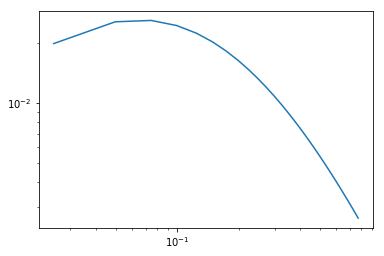

In [231]:
N = cosmology.N
k = np.sort(cosmology.freq[1:N//2])
plt.loglog(k, cosmology.P(k))

In [232]:
def norm_integrant(P, R):
    return lambda k: P(k) / (2 * np.pi**2) * W_th(R * k)**2 * k**2

In [233]:
cosmology.A = 1.0
cosmology.A = cosmology.sigma8 / quad(norm_integrant(cosmology.P, 8.0),
          (2*np.pi)/cosmology.L,
          np.inf)[0]

In [234]:
quad(norm_integrant(cosmology.P, 8.0),
     (2*np.pi)/cosmology.L,
     np.inf)[0]

/home/johannes/.local/share/workon/cosmology/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


0.8192277903435756

In [235]:
k = cosmology.k_abs.flat[1:]
np.sqrt(1. / cosmology.V * np.sum(cosmology.P(k) * W_th(8.0 * k)**2))

691.4208322899525